# Building and Training a CCNN from Scratch

In this notebook, we will build the architecture described in the [Correlator Convolutional Neural Network](https://arxiv.org/abs/2011.03474) paper, and use it to discriminate between some toy "quantum snapshots".

(Note: I have found that some images/plots look weird in the dark theme of Jupyter -- please use the light theme!)

First, we will need to install some libraries:

In [1]:
!pip install --user matplotlib numpy torch scikit-learn tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import linear_model
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
# Checking if you have a GPU and CUDA set up -- if not, training will take longer by running on the CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# Set the plotting style
plt.style.use('seaborn-poster')

## Background

Imagine we have quantum systems in two different states or phases, and we can only make projective measurements along some basis to probe them. Additionally, imagine we have some snapshots of an *unknown* system presumably in one of these two states, and we would like to tell which state it is actually in. If we know the correct order parameter ahead of time, it makes sense to just estimate these as best we can from the snapshots and use that. However, in many cases, such an order parameter is not known.

A data-science inspired solution is to build a machine learning (ML) *classifier* which, given a projective "snapshot" of the system, can reliably tell you which state it was sampled from. For many systems this is very possible, however a concerning problem in many modern ML approaches is that the learned classifiers are essentially *black boxes*: it is very hard to peer inside and figure out exactly how it is making its decisions. Hence, in the presence of noisy and/or simulated data, it can be difficult to trust that classifier is learning physically meaningful information rather than some artifact of the simulation or sampling process.

Our goal in this notebook is to build an ML classifier which is (1) simple/shallow enough that we can easily track the learned features and (2) specially designed such that the learned features directly correspond to physically meaningful information.

In this notebook, we will work with 2D square-lattice spin systems, where the snapshots are projective measurements of $\sigma_z$ on each site. Denote an example sampled snapshot by $S_k(\vec{x}) = \{0, 1\}$, where $S_1(\vec{x})$ is $1$ if we measured a spin-up at site $\vec{x}$ and zero otherwise, and $S_2(\vec{x}) = 1 - S_1(\vec{x})$ is $1$ if we measure a spin-down at site $\vec{x}$. We notice that we can think of this snapshot as a 2-channel image, with the spin-up information contained on the "red" channel, and the spin-down information is contained on the "blue" channel. Our goal then is to learn some function $\hat{y}(S) = \{0, 1\}$ that returns $0$ if the snapshot was sampled from state A, and $1$ if the snapshot was sampled from state B.

## Toy Data Generation

Let's generate some mock data that will approximate (or truly be) many-body "snapshots" sampled from different phases. We will generate data from a toy "thermal" phase with completely random spins, and train against Quantum Monte Carlo data sampled from a finite-temperature antiferromagnetic Heisenberg model. We will additionally generate another toy dataset mocking a noisy "stripe" phase.

Each of these functions returns a tuple of `torch.Tensor`'s, the first being a training set, and the second being a validation set. Each tensor is of the shape `[NSNAPS, 2, SIZE, SIZE]` where the first index indexes the snapshots in the train/val set, the second index is the spin up/down channels of the snapshots, and the last two indices are the row/column of the snapshot.

In [2]:
"""Generates completely random snapshots"""
def gen_random(num_snaps, size):
    snaps = torch.zeros(num_snaps, 2, size, size, dtype=torch.float32)
    # Set the spin-up channel to random {0, 1}
    snaps[:, 0, :, :] = torch.randint(2, (num_snaps, size, size))
    # Set the spin-down channel to 1 - spin_up
    snaps[:, 1, :, :] = 1 - snaps[:, 0, :, :]
    # Split into a train and val set
    num_train = int(0.9 * num_snaps)
    return snaps[:num_train], snaps[num_train:]

"""Loads the AFM Heisenberg data"""
def load_afm_data():
    data = pickle.load(open("./AFM.pkl", "rb"))
    snaps = torch.tensor(np.stack(data["snapshots"], axis=0), dtype=torch.float32)
    return snaps[data['train_idxs']], snaps[data['val_idxs']]

"""Generates mock `stripe` phase data"""
def gen_stripe(num_snaps, size):
    snaps = torch.zeros(num_snaps, 2, size, size, dtype=torch.float32)
    # Randomly pick the parity of the stripes
    if np.random.randint(2) == 0:
        snaps[:, 0, ::2, :] = 1
    else:
        snaps[:, 0, 1::2, :] = 1
    # Randomly flip spins with probability 0.3 to make mock "thermal noise"
    flips = np.random.choice([0, 1], size=snaps[:, 0, :, :].shape, p=[0.7, 0.3])
    snaps[:, 0, :, :] += torch.tensor(flips) * (1 - 2 * snaps[:, 0, :, :])
    # Set the spin-down channel to 1 - spin_up
    snaps[:, 1, :, :] = 1 - snaps[:, 0, :, :]
    num_train = int(0.9 * num_snaps)
    return snaps[:num_train], snaps[num_train:]

Our AFM dataset has 10,000 snapshots of size 16x16, so we will also generate this many of each of the random phase and the stripe phase.

In [3]:
rand_train, rand_val = gen_random(10000, 16)
afm_train, afm_val = load_afm_data()
stripe_train, stripe_val = gen_stripe(10000, 16)

"""Assembles tensors of snapshots into torch.DataLoaders to use during training"""
def make_datasets(train_A, train_B, val_A, val_B, batch_size=256):
    train_tensors = torch.cat([train_A, train_B])
    val_tensors = torch.cat([val_A, val_B])
    # Class A is labeled with a 0, class B is labeled with a 1
    train_labels = torch.cat([
        torch.zeros(len(train_A), dtype=torch.int64),
        torch.ones(len(train_B), dtype=torch.int64)
    ])
    val_labels = torch.cat([
        torch.zeros(len(val_A), dtype=torch.int64),
        torch.ones(len(val_B), dtype=torch.int64)
    ])
    
    train_dataset = torch.utils.data.TensorDataset(train_tensors, train_labels)
    val_dataset = torch.utils.data.TensorDataset(val_tensors, val_labels)
    
    pin_memory = True if torch.cuda.is_available() else False
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=pin_memory
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=pin_memory
    )
    return train_loader, val_loader

We can take a peek at a few snapshots from each dataset to see what we're working with -- you don't need to worry too much about this code, it is just arranging a nice figure.

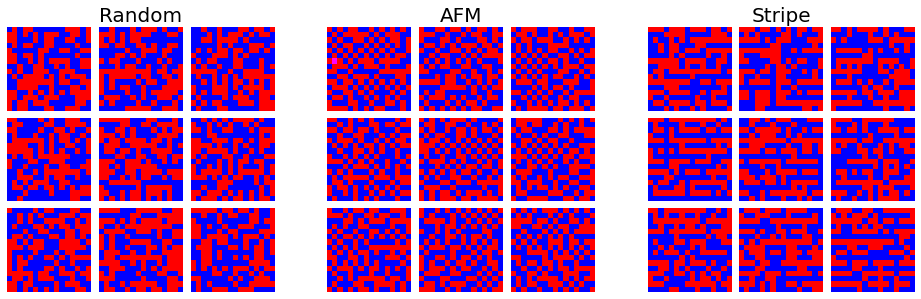

In [4]:
fig = plt.figure(constrained_layout=False, figsize=(14, 10))
outergrid = fig.add_gridspec(1, 3, left=0.05, right=0.95, wspace=0.2)
nsnaps = 3  # sqrt(Number of snapshots) to show from each dataset
center_idx = nsnaps // 2

snap_tensors = [rand_train, afm_train, stripe_train]
labels = ["Random", "AFM", "Stripe"]

"""Converts our snapshots to `images` which matplotlib can plot easily"""
def convert_image(snaps):
    # Add a dummy green channel
    snaps = np.stack((snaps[0], np.zeros_like(snaps[0]), snaps[1]))
    # Transpose to matplotlib image format
    img = snaps.transpose((1, 2, 0))
    return img 

for n, (snapset, label) in enumerate(zip(snap_tensors, labels)):
    innergrid = outergrid[0, n].subgridspec(nsnaps, nsnaps, wspace=0.10, hspace=-0.75)
    for i in range(nsnaps):
        for j in range(nsnaps):
            snap = snapset[nsnaps * i + j]
            img = convert_image(snap)
            
            ax = fig.add_subplot(innergrid[i, j])
            ax.axis('off')
            ax.imshow(img)
            
            if i == 0 and j == center_idx:
                ax.set_title(label, fontsize=20)

plt.show()

For these toy models, we can already visually see the difference in correlations between the distributions. The AFM snapshots have small patches of checkboard patterns, the stripe snapshots have small patches of horizontal lines of spins, and the random snapshots have no clear pattern.

Our goal will then to be to train an interpretable model to discriminate between these distributions, and verify that it is correctly picking up these features.

## Background: Convolutions / Convolutional Neural Networks

(If you are familiar with standard CNNs, you can skip ahead to the "CCNN Architecture" section).

For image-like classification problems, the most common ML architecture is the "Convolutional Neural Network". Given our "image" $S_k(\vec{x})$, a CNN learns a set of *convolutional filters* $f_{\alpha, k}(\vec{a})$, where the filter set is indexed by $\alpha=\{1, \dots, N_{\text{filt}}\}$ and each individual filter is indexed by channel $k=\{1, 2\}$ and space $\vec{a}$ in some small (say, $3\times 3$) window. These filters are small kernel "images" that are slid around the input image to product an output "image" $C$:

$$C_\alpha(\vec{x}) = \sum_{k, \vec{x}} f_{\alpha, k}(\vec{a}) S_k(\vec{x} + \vec{a})$$

This, being a linear operation, is generally followed up by some nonlinear function $\sigma$ applied pixelwise to produce $\sigma(C_\alpha(\vec{x}))$. The intuition here is that the values of $f_{\alpha, k}(\vec{a})$ are free learnable parameters, and the model tries to learn the filters to identify patterns in the input which are characteristic of the two classes. "Deep" CNNs will repeat this operation multiple times, convolving another set of learnable filters with $C$ to produce a new image, which is then convolved with further filters, or downsampled ("pooled"), or various other transformations until a final output $\hat{y}$ is produced, as shown below:

<img src=https://www.mdpi.com/entropy/entropy-19-00242/article_deploy/html/images/entropy-19-00242-g001.png width=1000>

However, in this notebook we will be building an extremely *shallow* network containining only a single convolution for easy interpretation, so it is important to understand this core operation.

As an example, the cell below shows the result of convolving an example convolutional filter with an image taken from the stripe dataset:

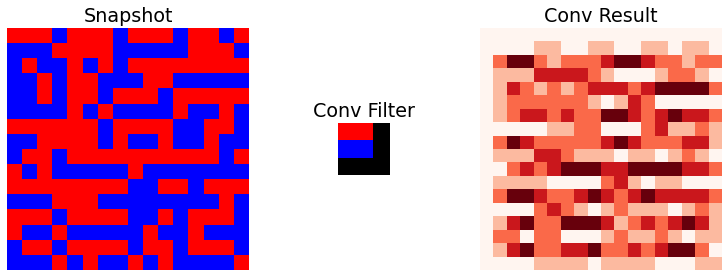

In [5]:
filt = torch.tensor([[
    [[1., 1., 0.],
     [0., 0., 0.],
     [0., 0., 0.]],
    
    [[0., 0., 0.],
     [1., 1., 0.],
     [0., 0., 0.]]
]])

snap = stripe_train[:1]
conv_result = F.conv2d(snap, filt, stride=1, padding=2)

fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [14, 3, 14], 'wspace': 0.5})
axs[0].imshow(convert_image(snap[0]))
axs[0].axis('off')
axs[0].set_title('Snapshot')

axs[1].imshow(convert_image(filt[0]))
axs[1].axis('off')
axs[1].set_title('Conv Filter')

res_img = axs[2].imshow(np.transpose(conv_result[0], (1, 2, 0)), cmap='Reds')
axs[2].axis('off')
axs[2].set_title("Conv Result")

plt.show()

An important thing to understand is that the input image is 2-channel: the red channel is $+1$ if a spin-up was sampled at a site, the blue channel is $+1$ if a spin-down was sampled at a site. The convolutional filter is also two-channel, containing weights which couple to both the spin-up and spin-down variables. However, *the output is 1-channel*, which just contains an "intensity" which is the result of a local "dot-product" of the filter with a patch of the image. If you learn $N_{\text{filt}}$ different filters, and stack all of the ouputs together, you then produce an $N_{\text{filt}}$-channel image from the 2-channel input.

Notice: The output of the convolution is high-intensity when the pattern of the filter "matches up" with the pattern in the snapshot, and low-intensity where it does not. The intuition of CNNs is then that you want to *automatically* learn the correct filters which identify "important" patterns in the input images.

How do we learn these filters? The general idea is the same as with all deep learning classification problems. We have a dataset of snapshots sampled from the two distributions, which we label with $y = \pm 1$ depending on which class they are. Starting with a randomly initialized model, we will iterate through the dataset, processing a random handful (a *minibatch*) of snapshots at a time. For each batch, we compute the outputs of our model as $\hat{y}$. We then compare $\hat{y}$ to $y$ with some *loss function* $L(y, \hat{y})$ which is minimized when the model is completely correct. Then, the parameters of the model can be updated according to gradient descent: $f_{\alpha, k}(\vec{a}) \leftarrow f_{\alpha, k}(\vec{a}) + \eta \frac{\partial L}{\partial f_{\alpha, k}(\vec{a})}$, where $\eta$ is the *learning rate*. (There are also more complicated update schemes which include more -- we will use [ADAM](https://arxiv.org/pdf/1412.6980.pdf)). The great thing about neural networks is that these gradients can be efficiently computed by *automatic backpropagation*, which is essentially a repeated application of the chain rule which is done automatically by deep learning libraries.

Details of these steps will be provided in the "Training" section below.

## CCNN Architecture

Below, we'll define the "simplest" CCNN architecture. 

The CCNN is a variation of the CNN, which slightly tweaks the nonlinear operation step to extract various orders of correlators out of a convolution. One way to understand these operations is as "nonlinear convolutions" which couple different numbers of pixels, defined by the operations:

$$ C_\alpha^{(1)}(\vec{x}) = \sum_{\vec{a}_1, k_1} f_{\alpha, k_1}(\vec{a}_1) S_{k_1}(\vec{x} + \vec{a}_1)$$
$$ C_\alpha^{(2)}(\vec{x}) = \sum_{(\vec{a}_1, k_1) \ne (\vec{a}_2, k_2)} f_{\alpha, k_1}(\vec{a}_1) f_{\alpha, k_2}(\vec{a}_2) S_{k_1}(\vec{x} + \vec{a}_1) S_{k_2}(\vec{x} + \vec{a}_2)$$

$$ \vdots $$

$$ C_\alpha^{(N)}(\vec{x}) = \sum_{(\vec{a}_1, k_1) \ne \dots \ne (\vec{a}_N, k_N)} \prod_{j=1}^N f_{\alpha, k_j}(\vec{a}_j) S_{k_j}(\vec{x} + \vec{a}_j)$$

Note that $C^{(1)}$ is the standard convolution as explained in the previous section. Each higher $C^{(n)}$, in expectation, measures a weighted sum of $n$-point correlators, where the weight on each correlator is equal to the product of the filter weights which make up that correlator's pattern.

Note that each of the sums are restricted such that terms where the same index pair $(\vec{a}_j, k_j)$ is not selected twice. This is to make interpretation easier down the line, as this way when interpreting what $C^{(n)}$ measures, one only needs to pick out the $n$-pixel patterns from the convolutional filter. Without this restriction, since $S$ only takes on values $\{0, 1\}$, it would be necessary to inspect all patterns in the filter with $\le n$ pixels, which would be a hassle!

However, this restriction also makes the sums difficult to compute naively. Luckily, one can show a nice recursive formula:

$$ C_\alpha^{(n)}(\vec{x}) = \frac{1}{n}\sum_{l=1}^n (-1)^{l-1} \left(\sum_{\vec{a}, k} f_{\alpha, k}(\vec{a})^l S_k(\vec{x} + \vec{a})^l \right) C_\alpha^{(n-l)}(\vec{x}) $$

Where all powers shown are done pixelwise. Using this, we can compute "correlator maps" up to $C^{(N)}$ in time $\mathcal{O}(N^2)$. This equation provides an alternate way to understand the nonlinear operation, as a modification of the function $\sigma$ to be a set of *polynomials* where the coefficients are carefully chosen to cancel out lower-order correlators.

Following this, there are just a few more components to the CCNN, as seen in the figure below, and explained afterwards. (**NOTE**: The figure below is working with 3-channel snapshots, with an additional channel containing information about the locations of holes in doped system. The model we will be building will work with 2-channel snapshots (learning 2-channel filters), since all of our test systems are "half-filled".)

![CCNN Architecture](arch.png)

If we know ahead of time that the pixel/site statistics are translation-invariant in our image, then we may as well take spatial averages of our correlator maps to produce:

$$c_\alpha^{(n)} = \frac{1}{N_{\text{sites}}} \sum_{\vec{x}} C_\alpha^{(n)}(\vec{x})$$

We'd then like to use these average correlations to distinguish the snapshots. Practically speaking, it is helpful to normalize each of these to zero mean and unit variance before using them in a classifier. Since the weights are constantly updating, this is difficult to do, but can be achieved on the batch scale using a [Batch Normalization](https://arxiv.org/abs/1502.03167v3) layer. (These are typically used as a "trick" in deep networks to speed up training, but here is important because the scales of each $c^{(n)}$ are so different, which isn't good for classification. It will also be important later in the interpretation stage.). 

What this layer does is simply normalize the features created from each *batch* of examples to have zero mean and unit variance within the batch.

Following this, we just use these features as inputs to a logistic classifier. If you are familiar with neural networks, this is really just a fully connected layer, followed by the `softmax` operation. We will label the learned weights coupling each $c_\alpha^{(n)}$ to the output as $\beta_\alpha^{(n)}$, and the final output of the neural network is:

$$\hat{y} = \frac{1}{1+ e^{-\vec{\beta}\cdot\vec{c} + \epsilon}}$$
where $\epsilon$ is a trainable bias parameter.

With all this in mind, lets construct a CCNN!

In [6]:
""" Implements the non-linear convolution operation using the recursive formula."""
class NonlinearConv(nn.Module):
    def __init__(self, in_channels=2, num_filts=2, filter_size=3, order=4):
        super().__init__()
        self.order = order
        self.in_channels = in_channels
        self.num_filts = num_filts
        self.filter_size = filter_size

        # Initialize filter similar as to how Pytorch initializes nn.Conv2d, but all positive
        weight_sample_k = np.sqrt(1.0 / (9 * in_channels))
        init_filt = (
            2 * weight_sample_k * torch.rand(num_filts, in_channels, filter_size, filter_size)
        )
        self.conv_filt = torch.nn.Parameter(init_filt)

    def forward(self, x):
        # We will work with strictly positive filters for easier interpretation!
        abs_filt = self.conv_filt.abs()

        # Convolutions of powers of the input with powers of the absolute valued filter
        # Since we know our input x takes values {0, 1}, that power isn't strictly necessary
        #   but is left here for demonstration
        conv_powers = [F.conv2d(x ** k, abs_filt ** k, stride=1, padding=2) for k in range(1, self.order + 1)]

        # F_0 is defined to be one everywhere
        corrs = [torch.ones_like(conv_powers[0])]

        # Compute each order of F_n recursively
        for n in range(1, self.order + 1):
            Fn = torch.zeros_like(conv_powers[0])
            for k in range(n):
                Fn += (-1) ** k * conv_powers[k] * corrs[n - k - 1]
            Fn /= n
            corrs.append(Fn)

        # Stack correlator maps along the channel dimension, dropping the zeroth order
        return torch.cat(corrs[1:], dim=-3)

    
""" Does a simple average over the last two dimensions of the input.
"""
class Mean2d(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.mean((-2, -1))
    

""" The full CCNN is Input -> NonlinearConv -> Spatial Avg -> BatchNorm -> Logistic. The way it is constructed
     here assumes a binary classification task, but this can be extended to the multiclass case.
"""
class CCNN(nn.Module):
    def __init__(self, in_channels=2, num_filts=1, filter_size=3, order=4, absbeta=True):
        super().__init__()
        self.order = order
        self.in_channels = in_channels
        self.num_filts = num_filts
        self.filter_size = filter_size
        self.absbeta = absbeta
        
        self.corr_conv = NonlinearConv(in_channels, num_filts, filter_size, order)
        self.spatial_mean = Mean2d()
        self.bn = nn.BatchNorm1d(num_filts * order, affine=False, eps=1e-7)
        self.logistic_fc = nn.Linear(num_filts * order, 1)
        
    def forward(self, x):
        x = self.corr_conv(x)
        x = self.spatial_mean(x)
        x = self.bn(x)
        # If absbeta is set, force the beta_alpha^(n) parameters to be strictly positive
        # The effect of this is that the model can only pick up features which "give evidence for"
        #  class A, to ensure we pick up characteristics of the AFM snapshots. (Rather than
        #  "characteristics of random noise, relative to AFM")
        if self.absbeta:
            self.logistic_fc.weight.data.abs_()
        x = self.logistic_fc(x)
        # Treat the output as if logit 0 has the value predicted by model, logit 1 has logit 0
        x = torch.cat((x, torch.zeros_like(x)), dim=-1)
        return x

One note on a confusing bit of code at the end of the CCNN definition:

`x = torch.cat((x, torch.zeros_like(x)), dim=-1)`

Since we are doing binary classification, it is only strictly necessary for the model to output a single number (the probability of class 1). However, the Pytorch loss function we will use ([nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)) expects two outputs: the [log-odds](https://en.wikipedia.org/wiki/Logit) of both classes. If these are $[\omega_1, \omega_2]$, then the resulting class probabilities are given by $p_1 = e^{\omega_1} / (e^{\omega_1} + e^{\omega_2}), p_2 = e^{\omega_2} / (e^{\omega_1} + e^{\omega_2})$. When there are only two classes, there is really only one independent variable here, so this line in our model is doing is simply outputting $[\omega_1, 0]$.

Before moving onto training, we can perform a sanity test that it's behaving as we expect by feeding a few (4) snapshots into it.

In [7]:
ccnn = CCNN()
ccnn(afm_train[:4])

tensor([[-1.3020,  0.0000],
        [ 0.2502,  0.0000],
        [-0.2884,  0.0000],
        [ 2.6480,  0.0000]], grad_fn=<CatBackward>)

As said, for each snapshot the model outputs $[\omega_1, 0]$, where $\omega_1$ is the log-odds of class one. To get real probabilities, we can take the [softmax](https://en.wikipedia.org/wiki/Softmax_function) of the output.

In [8]:
F.softmax(ccnn(afm_train[:4]), dim=-1)

tensor([[0.2138, 0.7862],
        [0.5622, 0.4378],
        [0.4284, 0.5716],
        [0.9339, 0.0661]], grad_fn=<SoftmaxBackward>)

Now we get probabilities! This softmax operation is already going to happen internally in our loss function, which is why our model outputs logits. (If this is all confusing, then do not worry too much -- these are really just details of how we need to make the model work with Pytorch's built-in loss functions).

It seems the network doesn't really know what it's doing yet -- let's fix that!

## Training

First, let's train the model to discriminate between AFM snapshots and Random snapshots.

We'll need to:

1) Create the train/val `torch.utils.data.DataLoader`'s
2) Create a torch optimizer, set a learning rate schedule, define the loss function
3) Run a training loop, reporting out some statistics as we train

The loss function we'll use to train is the [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) loss, which will measure how different the probabilities output from our model are from the true probabilities. Additionally, to bias our model to look for *simple* patterns, we are going to add an L1 (or [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics))) regularization loss to the filter weights. Intuitively, what this will do is force most of the pixels in the filters to be zero -- only pixels which meaningfully contribute to the model performance should be left activated.

So, the full loss function is:

$$L(y, \hat{y}; f_\alpha) = \underbrace{-y\log(\hat{y}) - (1 - y)\log(1 - \hat{y})}_{\text{Cross Entropy}} + \underbrace{\gamma \sum_{\alpha, k, \vec{a}} | f_{\alpha, k}(\vec{a})|}_{\text{L1 Regularization}} $$

where $y = \{0, 1\}$ is the label of the snapshot, $\hat{y}$ are the probabilities output by the model, and $\gamma$ is a hyperparameter which controls how strong the regularization loss is compared to the classification loss.

Now, let's go!

In [9]:
#=== 1) Create AFM/Random DataLoaders ===#
train_loader, val_loader = make_datasets(afm_train, rand_train, afm_val, rand_val)

#=== 2) Set up some things for training ===#
# Number of times the model will see the full dataset
epochs = 30
# The initial learning rate -- an important hyperparameter
lr = 0.05
# The strength of the regularization loss -- we can make this very strong in these easy toy examples
gamma = 0.5
# Thu number of filters to learn in our model
num_filts = 2
# The spatial length of the filters
filter_size = 3
# Make our model -- for simplicity, let's train a two-filter model
ccnn = CCNN(num_filts=num_filts, filter_size=filter_size, absbeta=True).to(device=device)
# The optimizer
optimizer = torch.optim.Adam(ccnn.parameters(), lr=lr)
# A learning schedule which will ramp down the learning rate as we train
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.85)
# Our loss function
criterion = nn.CrossEntropyLoss()

"""Performs one training epoch, feeding an entire DataLoader through a model,
    performing gradient descent and keeping track of the average loss and accuracy.
"""
def train(model, optimizer, criterion, loader, gamma=0.0, device='cuda'):
    model.train()
    loss_total = 0.0
    accuracy_total = 0.0
    for inpts, labels in loader:
        # Zero out gradients from the previous iteration
        optimizer.zero_grad()
        
        # Send the inputs and outputs to the GPU (if using one)
        inpts = inpts.to(device)
        labels = labels.to(device)

        # Feed the input through the network, measure the loss
        pred = model(inpts)
        loss = criterion(pred, labels)
        
        # Add our regularization loss on the filter weights
        l1_loss = model.corr_conv.conv_filt.norm(1)
        loss += gamma * l1_loss

        # Backprop gradients
        loss.backward()
        # Update model parameters by one gradient descent step
        optimizer.step()

        # Do some bookkeeping of the current loss and accuracy
        loss_total += loss.item()
        pred_classes = pred.argmax(dim=1).cpu()
        labels = labels.cpu()
        accuracy_total += torch.count_nonzero(pred_classes == labels).item() / len(pred_classes)

    avg_loss = loss_total / len(loader)
    avg_acc = accuracy_total / len(loader)
    return avg_loss, avg_acc

"""Performs one validation epoch, feeding an entire DataLoader through a model, and
    calculating the average loss and accuracy.
"""
def val(model, criterion, loader, gamma=0.0, device='cuda'):
    model.eval()
    loss_total = 0.0
    accuracy_total = 0.0
    
    with torch.no_grad():
        for inpts, labels in loader:
            inpts = inpts.to(device)
            labels = labels.to(device)

            pred = model(inpts)
            loss = criterion(pred, labels)

            l1_loss = model.corr_conv.conv_filt.norm(1)
            loss += gamma * l1_loss

            loss_total += loss.item()
            pred_classes = pred.argmax(dim=1).cpu()
            labels = labels.cpu()
            accuracy_total += torch.count_nonzero(pred_classes == labels).item() / len(pred_classes)
            
    avg_loss = loss_total / len(loader)
    avg_acc = accuracy_total / len(loader)
    return avg_loss, avg_acc

#=== 3) The main training loop! ===#
# Some lists to keep track of losses and accuracies
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in tqdm(range(epochs), desc="Epoch"):
    # Train
    train_loss, train_acc = train(
        ccnn, optimizer, criterion, train_loader,
        gamma=gamma, device=device
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Val
    val_loss, val_acc = val(
        ccnn, criterion, val_loader,
        gamma=gamma, device=device
    )
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Step the learning rate schedule
    lr_scheduler.step()

Epoch: 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Let's look at how the training went!

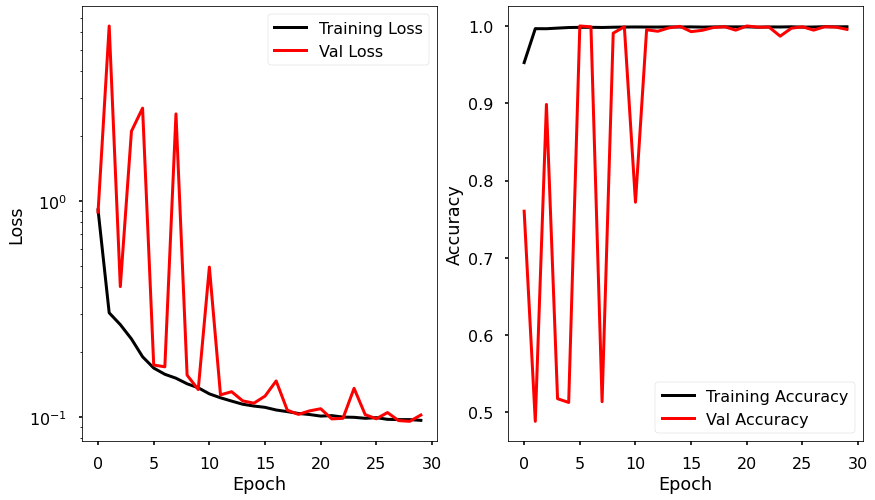

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

# Plot the losses
axs[0].plot(np.arange(epochs), train_losses, lw=3, color='k', label="Training Loss")
axs[0].plot(np.arange(epochs), val_losses, lw=3, color='r', label="Val Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_yscale('log')
axs[0].legend()
# Plot the accuracies
axs[1].plot(np.arange(epochs), train_accs, lw=3, color='k', label="Training Accuracy")
axs[1].plot(np.arange(epochs), val_accs, lw=3, color='r', label="Val Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.show()

Great! It seems like our model is going a good job of classifying, close to 100% accuracy! Notice a couple things:


1) The training and validation losses are right on top of each other! This is important because it means we are not overfitting or "memorizing" the training dataset, and are thus learning real generalizable features. The primary reason our model seldom overfits is because the total number of parameters in the model is so small compared to large, deep neural networks. Of course, this means that the class of features it can learn are "simpler" (we will not be classifying dogs and cats with this model), but in many physical contexts this is sufficient!

2) The validation accuracy can greatly lag behind the classification accuracy at early times and is a bit noisy overall. This is primarily due to the fact that `nn.BatchNorm2d` behaves differently at training and validation time. During training, the normalization is done with *batch* statistics, while during validation, the normalization is done with statistics over the entire history of examples the model has seen. When the model parameters are still varying greatly, the former can be much more accurate than the latter.

3) The loss is plateau'ing out at the end, but can probably still go a bit further down. This is from fine-tuning of the filter parameters to try and minimize the L1 loss while still maintaining performance. For this example, training longer will not improve classification performance any further, but can result in "cleaner" filters with more pixels de-activated.


Feel free to play around with the hyperparameters above! Some things that you can tweak are:

- The initial learning rate, `lr`
- The [learning rate schedule](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate), `lr_schedule`
- The number of training epochs, `epochs`
- The L1 regularization strength, `gamma`
- The number of convolutional filtesrs, `num_filters`
- The order of the model, `order`

However, the next section of the notebook assumes `num_filters = 2` and `order = 4`, so set those back and re-train before moving on!

## Interpretation - Regularization Paths

The final step! Let's look at what the model has learned.

The simplest way to do so is just to look at the convolutional filters themselves.

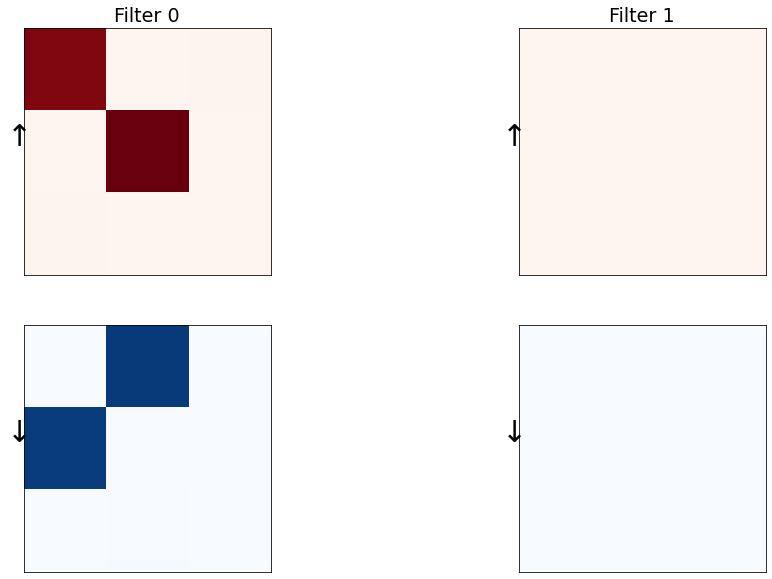

In [11]:
fig = plt.figure(constrained_layout=False, figsize=(14, 10))
outergrid = fig.add_gridspec(1, 2, left=0.05, right=0.95, wspace=0.2)

filters = ccnn.corr_conv.conv_filt.data.abs().detach().cpu().numpy()

#== Plotting code ==#
# Make sure that all filters are plotted on the same colorscale
vmin = filters.min()
vmax = filters.max()
chan_cmaps = ['Reds', 'Blues']
chan_labels = ['↑', '↓']
for n in range(2):
    filtgrid = outergrid[0, n].subgridspec(2, 1, wspace=0.1)
    for chan in range(2):
        ax = fig.add_subplot(filtgrid[chan, 0])
        if chan == 0:
            ax.set_title("Filter " + str(n))
        ax.imshow(filters[n, chan], cmap=chan_cmaps[chan], vmin=vmin, vmax=vmax)
        ax.tick_params(
            bottom=False,
            labelbottom=False,
            left=False,
            labelleft=False,
        )
        ax.set_ylabel(chan_labels[chan], rotation=0, fontsize=30)
plt.show()

If everything has gone to plan, you will notice that one filter is completely blank, while the other filter contains a pattern that suspiciously looks like the AFM checkerboard pattern. This is reassuring -- our model is picking up the features we know are truly the important ones for distinguishing these distributions.

While at this point we know the model is measuring something like "patterns which look like a checkerboard", we still don't know *exactly* what the quantity the model is measuring is. We know our model is using this checkerboard filter to build several nonlinear maps $C^{(n)}(\vec{x})$, then spatially averaging them to produce $c^{(n)}$, then making a classification based off of these. We also know that each $c^{(n)}$ precisely measures a weighted sum of $n$-point correlators, in this case all of the correlators which are compatible with the AFM pattern found in the filter.

But, *which* $c^{(n)}$ is being used? Does the model really *need* to measure fourth-order correlations to classify between the models, or are lower-point measurements sufficient? We can answer these questions by constructing a *regularization path*.

In this process, we will *hold the filters $f_\alpha$ frozen*, and re-train the logisitic classifier. Additionally, we will train the logistic classifier with an L1 loss on the *logistic weights*, $\beta_\alpha^{(n)}$.

$$L(y, \hat{y}; \beta_\alpha^{(n)}) = \underbrace{-y\log(\hat{y}) - (1 - y)\log(1 - \hat{y})}_{\text{Cross-Entropy}} + \underbrace{\lambda \sum_{\alpha, n} ||\beta_\alpha^{(n)}||}_{\text{L1 Regularization}}$$

As in the first training run, the point of this regularization loss is to reduce the number of parameters the model is using. If we make the regularization strength $\lambda$ very large, then the training process will focus on killing all $\beta_\alpha^{(n)}$, even at the cost of completely giving up on classification. We can then *slowly* reduce $\lambda$, continually re-training the model, and look for the point where the *first* feature $\beta_\alpha^{(n)}$ is activated. At this point, we know that the model is *only* using $c_\alpha^{(n)}$ for its classification decision, and hence *only* measuring $n$-point correlations.

We will do a couple tricks to make this whole process proceed a lot faster.

1) Since the convolutional filters are frozen, there is no point of computing the convolutions on every forward pass. So, we may as well precompute all of these once at the beginning and then just work with the $c_\alpha^{(n)}$ from then on
2) We will make sure that the $c_\alpha^{(n)}$ are completely properly normalized to zero mean and unit variance
3) We will use `sklearn` to train the logistic regression -- it will be much more accurate and fast than an implementation we can write

In [12]:
#=== Steps (1) + (2): Preprocessing ===#

#=== 1) Precompute all of the c_α^(n) ===#

# Make a model which is only the "front half" of the CCNN, stopping before applying the nn.Linear
chopped_ccnn_modules = []
for module in list(ccnn.modules())[1:]:
    if type(module) is not nn.Linear:
        chopped_ccnn_modules.append(module)
chopped_ccnn = nn.Sequential(*chopped_ccnn_modules)

# Pass all of the data through this model to obtain the c_α^(n) [corr_feats]
train_cαs, train_labels = [], []
val_cαs, val_labels = [], []
with torch.no_grad():
    for inpts, labels in train_loader:
        inpts = inpts.to(device=device)
        cα = chopped_ccnn(inpts).cpu()
        train_cαs.append(cα)
        train_labels.append(labels)
    for inpts, labels in val_loader:
        inpts = inpts.to(device=device)
        cα = chopped_ccnn(inpts).cpu()
        val_cαs.append(cα)
        val_labels.append(labels)
train_cαs = torch.cat(train_cαs).numpy()
train_labels = torch.cat(train_labels).numpy()
val_cαs = torch.cat(val_cαs).numpy()
val_labels = torch.cat(val_labels).numpy()

#=== 2) Normalize all c_α^{(n)} to zero mean and unit variance ===#
train_mean = train_cαs.mean(axis=0, keepdims=True)
train_std = train_cαs.std(axis=0, keepdims=True)
val_mean = val_cαs.mean(axis=0, keepdims=True)
val_std = val_cαs.std(axis=0, keepdims=True)
train_cαs = (train_cαs - train_mean) / (train_std)
val_cαs = (val_cαs - val_mean) / (val_std)

#=== 3) Set up a logistic regression problem using sklearn ===#
logistic_clf = sklearn.linear_model.LogisticRegression(
    penalty="l1", solver='saga', warm_start=True, tol=1e-4,
    fit_intercept=True, max_iter=int(1e4)
)
# A list of inv_λs to train the model at.
inv_λs = np.logspace(-4, 1, num=1000)
# Arrays/Lists to keep track of β_α^(n) and accuracies 
β_αs = np.empty((len(inv_λs), 4 * num_filts))
train_accs = np.empty(len(inv_λs))
val_accs = np.empty(len(inv_λs))

# Do the whole series of regressions!
for i, inv_λ in tqdm(enumerate(inv_λs), total=len(inv_λs)):
    # Set the regularization strength -- what sklearn calls C we call 1/λ
    logistic_clf.set_params(C=inv_λ)
    # Perform the regression
    logistic_clf.fit(train_cαs, train_labels)
    # Record the current coefficients β_α^(n)
    β_αs[i] = logistic_clf.coef_.ravel().copy()
    # Record the current accuracies
    train_accs[i] = logistic_clf.score(train_cαs, train_labels)
    val_accs[i] = logistic_clf.score(val_cαs, val_labels)

100%|██████████| 1000/1000 [00:40<00:00, 24.63it/s]


Now, lets look at the regularization path we have produced!

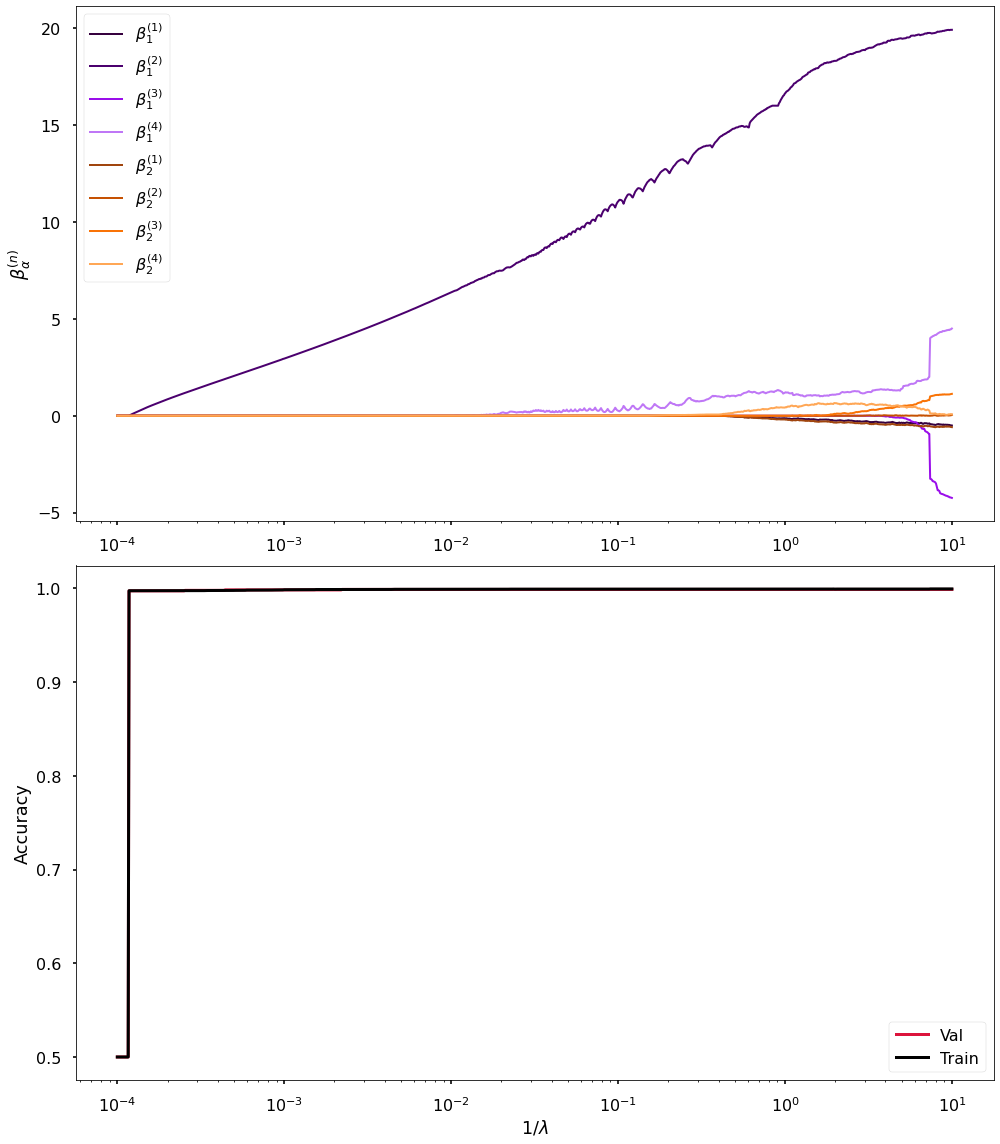

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(14, 16))
β_ax, acc_ax = axs[0], axs[1]

β_ax.set_xscale('log')
β_ax.set_ylabel(r"$\beta_\alpha^{(n)}$")
acc_ax.set_xscale('log')
acc_ax.set_ylabel("Accuracy")
acc_ax.set_xlabel(r"$1/\lambda$")

# Colors of each β trajectory
colors = [
    ["xkcd:deep purple", "xkcd:royal purple", "xkcd:violet", "xkcd:light purple"],
    ["xkcd:burnt umber", "xkcd:dark orange", "xkcd:orange", "xkcd:pale orange"],
]


for ifilt in range(num_filts):
    for iorder in range(4):
        # Index into β_αs
        iβ = iorder * num_filts + ifilt
        color = colors[ifilt][iorder]
        label = r"$\beta_" + str(ifilt+1) + "^{(" + str(iorder+1) + ")}$"
        # There's an overall sign difference in how we define β_α in our CCNN
        #  versus sklearn's LogisticRegression, so plot -β_α^(n)
        β_ax.plot(inv_λs, -β_αs[:, iβ], color=color, lw=2, label=label)
β_ax.legend()    

# Plot the accuracies
acc_ax.plot(inv_λs, val_accs, lw=3, color='crimson', label="Val")
acc_ax.plot(inv_λs, train_accs, lw=3, color='black', label="Train")
acc_ax.legend()
fig.tight_layout()

plt.show()

Nice! We've found out that our model really only needs to use the second-order correlations associated with the AFM filter, and that these provide evidence for class A, the AFM Heisenberg snapshots. The regularization path analysis found that the $\beta^{(2)}$ associated to this filter is the most "important", and we can get essentially 100% classification accuracy by simply measuring these two-point correlations!

To make it extremely explicit what the model is then measuring, the next snippet of code will plot out what correlations are being measured from this filter. Because of the feature normalization, the overall coefficient in front of this feature is meaningless, so we may as well scale the strongest correlation to have weight 1.0.

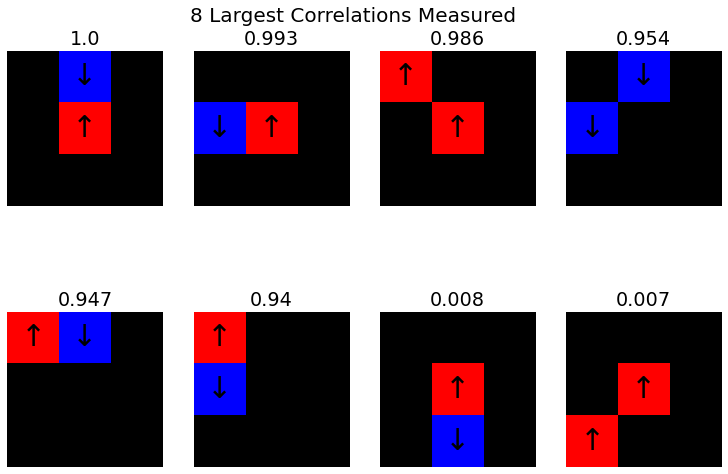

In [14]:
import itertools

two_point_weights = np.zeros((2, filter_size, filter_size, 2, filter_size, filter_size))
# An iterator which iterates over all *pairs* of pixels in the filter
pix_iter = itertools.product(
    range(2), range(filter_size), range(filter_size),
    range(2), range(filter_size), range(filter_size)
)

# Figure out which filter is the "active" one
active_filt_num = int(filters[1].max() > filters[0].max())
active_filt = filters[active_filt_num]

# Calculate the weight on each two-point correlator
for (ichan, ix, iy, jchan, jx, jy) in pix_iter:
    # Matrix is symmetric -- only compute upper triangle
    if (ichan, ix, iy) > (jchan, jx, jy):
        two_point_weights[ichan, ix, iy, jchan, jx, jy] = active_filt[ichan, ix, iy] * active_filt[jchan, jx, jy]

# Sort, collect the eight largest correlators measured (You can change this number!)
num_corr = 8
corr_idxs = np.argsort(two_point_weights.flatten())[-num_corr:][::-1]
corr_idxs = np.stack(np.unravel_index(corr_idxs, two_point_weights.shape), axis=1)
# Rescale correlators such that the largest has weight 1.0
two_point_weights /= two_point_weights.max()

# Plot these!
fig, axs = plt.subplots(2, int(np.ceil(num_corr/2)), gridspec_kw={'wspace': 0.2})
axs = axs.flatten()
fig.suptitle("{} Largest Correlations Measured".format(num_corr), y=0.9, fontsize=20)
for n, corr_idx in enumerate(corr_idxs):
    ichan, ix, iy, jchan, jx, jy = corr_idx
    corr_img = np.zeros((filter_size, filter_size, 3))
    icolor = [1.0, 0.0, 0.0] if ichan == 0 else [0.0, 0.0, 1.0]
    iarrow = "↑" if ichan == 0 else "↓"
    jcolor = [1.0, 0.0, 0.0] if jchan == 0 else [0.0, 0.0, 1.0]
    jarrow = "↑" if jchan == 0 else "↓"
    corr_img[ix, iy] = icolor
    corr_img[jx, jy] = jcolor
    axs[n].imshow(corr_img)
    axs[n].text(iy, ix, iarrow, ha="center", va="center", fontsize=30)
    axs[n].text(jy, jx, jarrow, ha="center", va="center", fontsize=30)
    axs[n].axis('off')
    axs[n].set_title(np.round(two_point_weights[ichan, ix, iy, jchan, jx, jy], decimals=3))
# Turn off axes of plots we're not using
for n in range(num_corr, 2 * int(np.ceil(num_corr/2))):
    axs[n].axis('off')
    
plt.show()

Each picture above shows a two point correlator that is measured by $c^{(2)}$, and the number above each picture shows the weight of that correlator, given by $f(\vec{a}_1) f(\vec{a}_2)$.

This makes it perfectly clear what the network is learning. It estimates the above two point correlators from the snapshot, then classifies the image as "AFM" or "Random" based on how high that estimate is.

Now, feel free to mess with any of the hyperparameters or distributions being studied -- and we also we didn't touch the stripe data yet! In the first cell under the "Training" heading, you can make the switch `afm_train, afm_val -> stripe_train, stripe_val` in the call to `make_datasets`, then re-run all of the cells below it to look at the behavior in this case.